# Masked Fitting Deblender with Single Unblended Donut

This notebook serves as a proof-of-concept for the masked fitting deblender by showing its ability to work on a single unblended donut with different masking.

## Imports

In [1]:
import os
from lsst.daf.butler import Butler
from lsst.afw import image as afwImage

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.Utility import runProgram, writePipetaskCmd, getConfigDir, CamType
from lsst.ts.wep.task.EstimateZernikesCwfsTask import EstimateZernikesCwfsTask, EstimateZernikesCwfsTaskConfig

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import rotate
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Load data

In [2]:
butler_repo_orig = 'testData/single_unblended/phosimData/'

In [3]:
butler_orig = Butler(butler_repo_orig)

In [72]:
dataIdExtra = {
    'instrument': 'LSSTComCam', 
    'detector': 6, 
    'exposure': 4021123106001,
    'visit': 4021123106001
}
dataIdIntra = {
    'instrument': 'LSSTComCam', 
    'detector': 6, 
    'exposure': 4021123106002,
    'visit': 4021123106002
}
donutStampsExtra = butler_orig.get('donutStampsExtra', dataId=dataIdExtra, collections='ts_phosim_9006001')
donutStampsIntra = butler_orig.get('donutStampsIntra', dataId=dataIdExtra, collections='ts_phosim_9006001')

In [73]:
len(donutStampsExtra)

1

In [74]:
donutStampExtra = donutStampsExtra[0]
donutStampIntra = donutStampsIntra[0]

In [75]:
donutStampExtraArray = donutStampExtra.stamp_im.getImage().getArray()

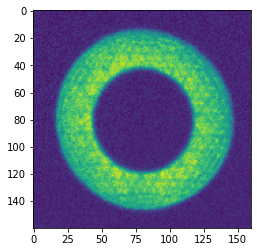

In [76]:
plt.imshow(donutStampExtraArray)

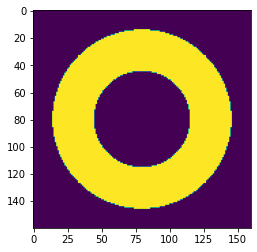

In [77]:
plt.imshow(donutStampExtra.stamp_im.getMask().getArray())

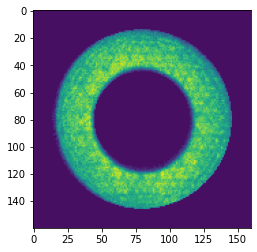

In [78]:
plt.imshow(donutStampExtra.stamp_im.getMask().getArray()*donutStampExtraArray)

In [79]:
camera = butler_orig.get(
    "camera",
    dataId={"instrument": "LSSTComCam"},
    collections="LSSTComCam/calib/unbounded",
)

In [80]:
camera.getName()

'LSSTComCam'

In [81]:
donutCatalogExtra = butler_orig.get('donutCatalog', dataId=dataIdExtra, collections='ts_phosim_9006001')

In [82]:
donutCatalogIntra = butler_orig.get('donutCatalog', dataId=dataIdIntra, collections='ts_phosim_9006001')

In [88]:
x_blend, y_blend = 2036.5, 2054.5
x_blend_2, y_blend_2 = 2036.5, 1945.5

In [89]:
# x_blend, y_blend = 2036.5, 2114.5
# x_blend_2, y_blend_2 = 2036.5, 1945.5

In [90]:
donutCatalogExtra['blend_centroid_x'] = [[x_blend]]
donutCatalogExtra['blend_centroid_y'] = [[y_blend]]

In [91]:
donutStampsExtra[0].blend_centroid_positions = np.array([[x_blend, y_blend], [x_blend, y_blend_2]])
donutStampsIntra[0].blend_centroid_positions = np.array([[x_blend, y_blend], [x_blend, y_blend_2]])

In [92]:
donutStampsExtra[0].blend_centroid_positions = np.array([[x_blend, y_blend]])
donutStampsIntra[0].blend_centroid_positions = np.array([[x_blend, y_blend]])

In [93]:
donutCatalogExtra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,0.004096,-0.004096,2036.840927,2000.123629,3.630781e+06,[2036.5],[2054.5]


In [94]:
donutCatalogIntra['blend_centroid_x'] = [[x_blend]]
donutCatalogIntra['blend_centroid_y'] = [[y_blend]]

In [95]:
donutCatalogIntra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,0.004096,-0.004096,2036.840927,2000.123629,3.630781e+06,[2036.5],[2054.5]


## Running a baseline donut with no modifications

In [96]:
zern_est_orig = butler_orig.get('zernikeEstimateRaw', dataId=dataIdExtra, collections='ts_phosim_9006001')

In [97]:
opd_truth = np.genfromtxt('testData/single_unblended/iter0/img/opd.zer')

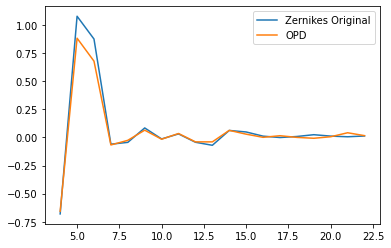

In [98]:
plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original')
#plt.plot(np.arange(4,23), zern_est_blended_baseline[0], label='Zernikes Blended Baseline')
plt.plot(np.arange(4,23), opd_truth[4], label='OPD')
plt.legend()

## Running the new deblending code with a modified mask simulating a blend

In [99]:
from lsst.ts.wep.task.CalcZernikesTask import CalcZernikesTask, CalcZernikesTaskConfig

In [100]:
calcZernConfig = CalcZernikesTaskConfig()

In [101]:
calcZernConfig

lsst.ts.wep.task.CalcZernikesTask.CalcZernikesTaskConfig(saveMetadata=True, saveLogOutput=True, combineZernikes={'sigma': 3.0, 'maxZernClip': 3}, connections={'donutStampsExtra': 'donutStampsExtra', 'donutStampsIntra': 'donutStampsIntra', 'outputZernikesRaw': 'zernikeEstimateRaw', 'outputZernikesAvg': 'zernikeEstimateAvg'})

In [102]:
calcZernTask = CalcZernikesTask(config=calcZernConfig)

In [103]:
# donutStampsIntra[0].centroid_position = donutStampsExtra[0].centroid_position

In [116]:
zern_est_new = calcZernTask.run(donutStampsExtra, donutStampsIntra)

1
0
1
0
[[-4.5 59.5]]
0
[[-4.5 59.5]]
0
[[-7.5 62.5]]
0
[[-7.5 62.5]]
0
2804.041425623214
825.5105062462333
3365.9647587265217
5115.994897190516
5470.578083509582
5261.961645729676
4379.904434458824
3762.790291986786
2305.638919419209
1259.398446632076
836.2790340573306
749.7678773821901
648.598658820036
641.678096649449


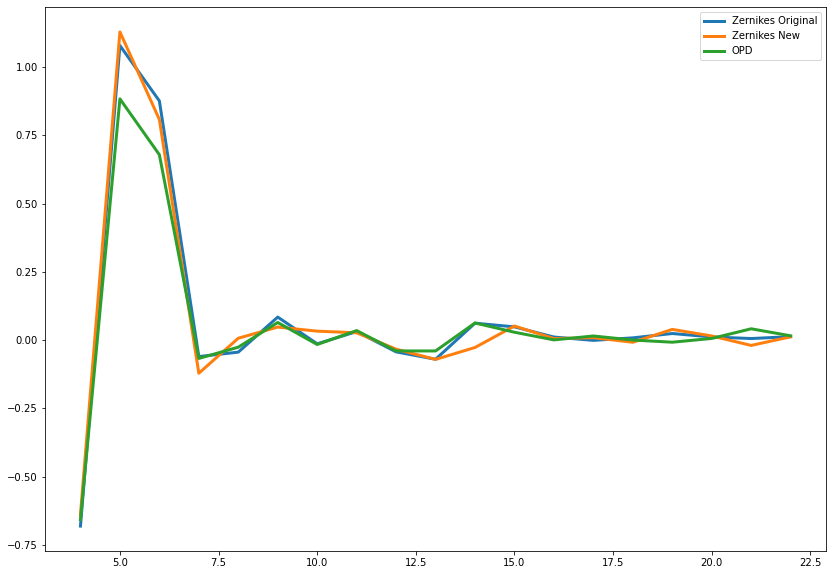

In [117]:
fig = plt.figure(figsize=(14, 10))
plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original', lw=3)
#plt.plot(np.arange(4,23), zern_est_blended_baseline[0], label='Zernikes Blended Baseline', lw=3)
plt.plot(np.arange(4,23), zern_est_new.outputZernikesRaw[0], label='Zernikes New', lw=3)
plt.plot(np.arange(4,23), opd_truth[4], label='OPD', lw=3)
plt.legend()

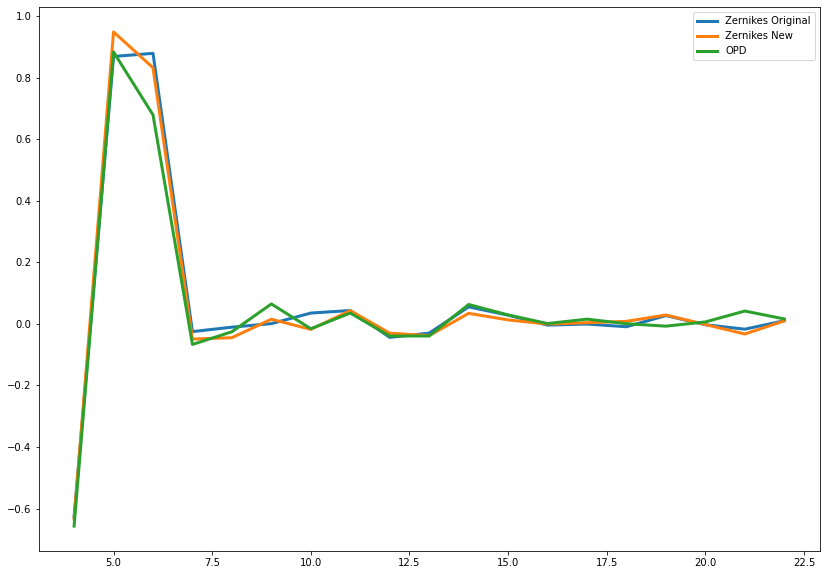

In [33]:
fig = plt.figure(figsize=(14, 10))
plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original', lw=3)
#plt.plot(np.arange(4,23), zern_est_blended_baseline[0], label='Zernikes Blended Baseline', lw=3)
plt.plot(np.arange(4,23), zern_est_new.outputZernikesRaw[0], label='Zernikes New', lw=3)
plt.plot(np.arange(4,23), opd_truth[4], label='OPD', lw=3)
plt.legend()

## Run donut with cutouts but mask is unblended

In [79]:
from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.cwfs.CompensableImage import CompensableImage
from lsst.ts.wep.Utility import getConfigDir, CamType, DefocalType

In [80]:
# Instrument configured with camera name and size of donut images
inst = Instrument(os.path.join(getConfigDir(), 'cwfs', 'instData'))
inst.config(CamType.LsstCam, 160)

In [81]:
donutStampsExtra[0]._setCompensableImage()
donutStampsExtra[0].makeMasks(inst, 'offAxis', 2, 1)
donutStampsIntra[0]._setCompensableImage()
donutStampsIntra[0].makeMasks(inst, 'offAxis', 2, 1)

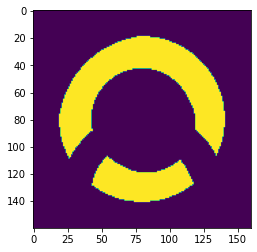

In [84]:
plt.imshow(donutStampsExtra[0].mask_pupil.getArray())

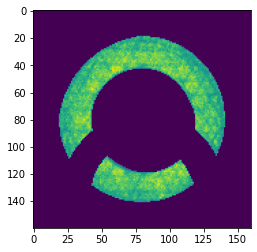

In [85]:
plt.imshow(donutStampsExtra[0].mask_pupil.getArray()*donutStampsExtra[0].stamp_im.getImage().getArray())

### Create new donutStamps for test case

In [87]:
from lsst.ts.wep.task.DonutStamp import DonutStamp
from lsst.ts.wep.task.DonutStamps import DonutStamps

from lsst.afw import image as afwImage
import lsst.geom

from copy import copy

In [134]:
dse = copy(donutStampsExtra[0])
dsi = copy(donutStampsIntra[0])

In [138]:
dse.stamp_im.image.array = np.array(donutStampsExtra[0].mask_pupil.getArray()*donutStampsExtra[0].stamp_im.getImage().getArray(), dtype=np.float32)
dsi.stamp_im.image.array = np.array(donutStampsIntra[0].mask_pupil.getArray()*donutStampsIntra[0].stamp_im.getImage().getArray(), dtype=np.float32)

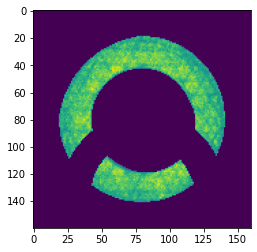

In [139]:
plt.imshow(dse.stamp_im.getImage().getArray())

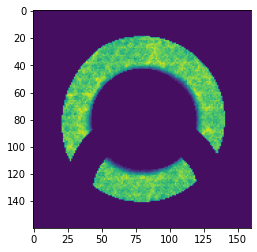

In [140]:
plt.imshow(dsi.stamp_im.getImage().getArray())

In [158]:
dse.blend_centroid_positions = np.array([], dtype=np.float64)
dse.blend_centroid_positions = dse.blend_centroid_positions.reshape(0,2)
dsi.blend_centroid_positions = np.array([], dtype=np.float64)
dsi.blend_centroid_positions = dsi.blend_centroid_positions.reshape(0,2)

In [159]:
modDonutStampsExtra = DonutStamps([dse])
modDonutStampsIntra = DonutStamps([dsi])

In [160]:
modDonutStampsExtra[0]._setCompensableImage()
modDonutStampsExtra[0].makeMasks(inst, 'offAxis', 2, 1)
modDonutStampsIntra[0]._setCompensableImage()
modDonutStampsIntra[0].makeMasks(inst, 'offAxis', 2, 1)

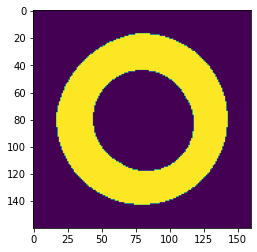

In [161]:
plt.imshow(modDonutStampsExtra[0].mask_comp.getArray())

In [168]:
zern_est_modified_donut = calcZernTask.run(modDonutStampsExtra, modDonutStampsIntra)

(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e

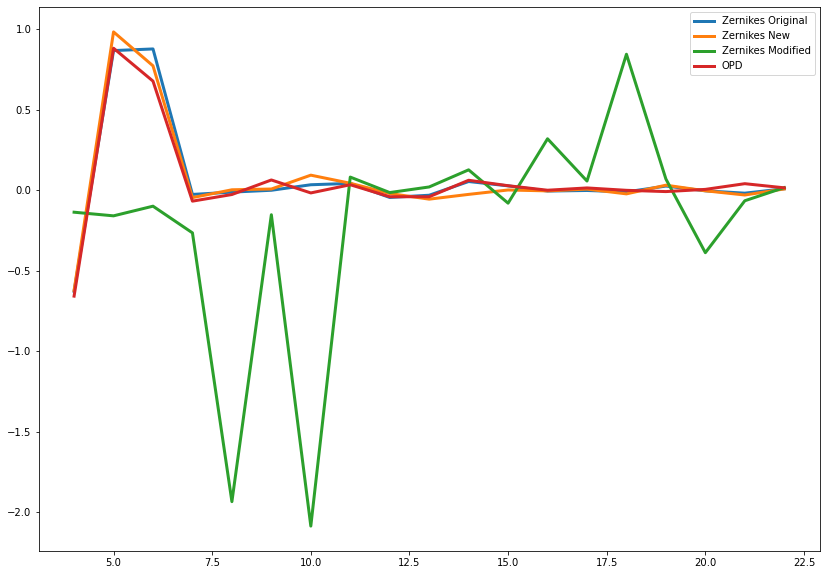

In [169]:
fig = plt.figure(figsize=(14, 10))
plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original', lw=3)
plt.plot(np.arange(4,23), zern_est_new.outputZernikesRaw[0], label='Zernikes New', lw=3)
plt.plot(np.arange(4,23), zern_est_modified_donut.outputZernikesRaw[0], label='Zernikes Modified', lw=3)
plt.plot(np.arange(4,23), opd_truth[4], label='OPD', lw=3)
plt.legend()

In [170]:
I1 = np.genfromtxt('I1.txt')
I2 = np.genfromtxt('I2.txt')

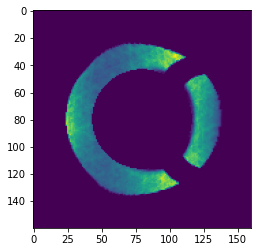

In [171]:
plt.imshow(I1)

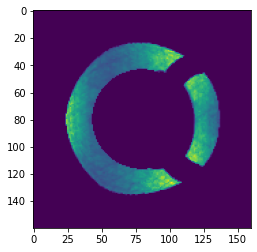

In [172]:
plt.imshow(I2)

## No modifications to donut, flip donut

In [173]:
dse = copy(donutStampsExtra[0])
dsi = copy(donutStampsIntra[0])

In [174]:
dse.blend_centroid_positions = np.array([], dtype=np.float64)
dse.blend_centroid_positions = dse.blend_centroid_positions.reshape(0,2)
dsi.blend_centroid_positions = np.array([], dtype=np.float64)
dsi.blend_centroid_positions = dsi.blend_centroid_positions.reshape(0,2)

In [175]:
modDonutStampsExtra = DonutStamps([dse])
modDonutStampsIntra = DonutStamps([dsi])

In [182]:
zern_est_flipped_donut = calcZernTask.run(modDonutStampsExtra, modDonutStampsIntra)

(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e-05, -2.777777777777225e-05) (-2.777777777779199e-05, -2.777777777777225e-05)
(-8.333333333333649e

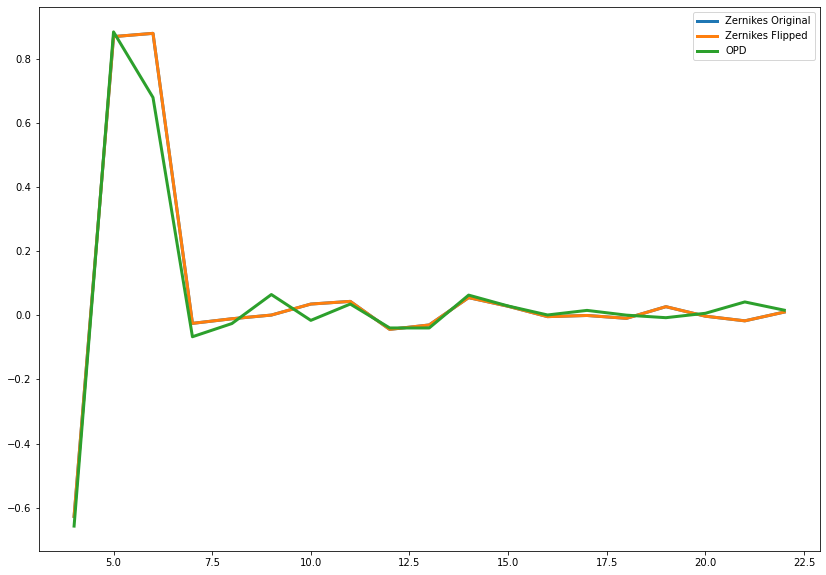

In [183]:
fig = plt.figure(figsize=(14, 10))
plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original', lw=3)
#plt.plot(np.arange(4,23), zern_est_new.outputZernikesRaw[0], label='Zernikes New', lw=3)
#plt.plot(np.arange(4,23), zern_est_modified_donut.outputZernikesRaw[0], label='Zernikes Modified', lw=3)
plt.plot(np.arange(4,23), zern_est_flipped_donut.outputZernikesRaw[0], label='Zernikes Flipped', lw=3)
plt.plot(np.arange(4,23), opd_truth[4], label='OPD', lw=3)
plt.legend()

In [106]:
I1 = np.genfromtxt('I1_0.txt')
I2 = np.genfromtxt('I2_0.txt')
I1_mod = np.genfromtxt('I1_mask_0.txt')
I2_mod = np.genfromtxt('I2_mask_0.txt')

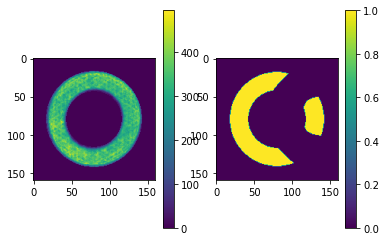

In [107]:
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(I1)
plt.colorbar()
fig.add_subplot(122)
plt.imshow(I1_mod)
plt.colorbar()

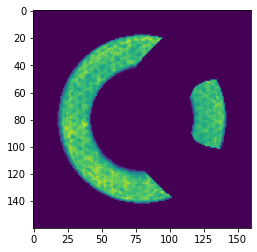

In [108]:
plt.imshow(I1*I1_mod)

In [109]:
I1 = np.genfromtxt('I1_4.txt')
I2 = np.genfromtxt('I2_4.txt')
I1_mod = np.genfromtxt('I1_mask_0.txt')
I2_mod = np.genfromtxt('I2_mask_0.txt')

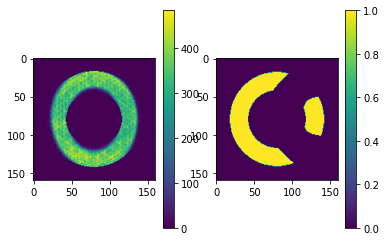

In [110]:
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(I1)
plt.colorbar()
fig.add_subplot(122)
plt.imshow(I1_mod)
plt.colorbar()

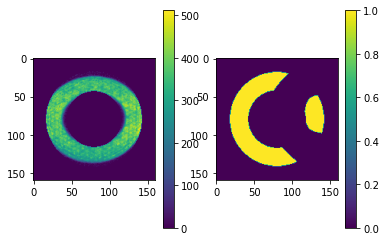

In [111]:
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(I2)
plt.colorbar()
fig.add_subplot(122)
plt.imshow(I2_mod)
plt.colorbar()

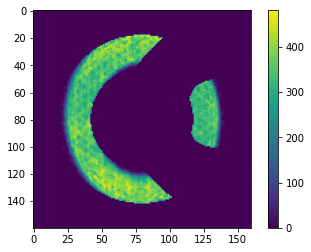

In [112]:
plt.imshow(I1*I1_mod)
plt.colorbar()

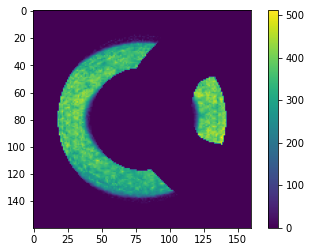

In [113]:
plt.imshow(I2*I2_mod)
plt.colorbar()

In [114]:
i0 = np.genfromtxt('I0_0.txt')
dI = np.genfromtxt('dI_0.txt')

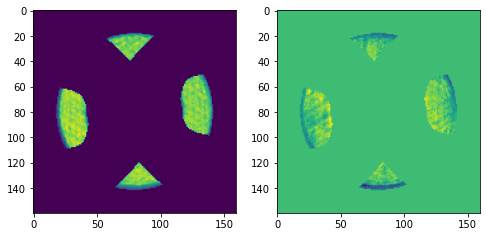

In [115]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(121)
plt.imshow(i0)
#plt.colorbar()
fig.add_subplot(122)
plt.imshow(dI)
#plt.colorbar()